In [1]:
import numpy as np
import numpy.matlib
import matplotlib
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import sys,os
import importlib
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import datetime
import seaborn as sns
import pandas as pd
import scipy
import scipy.spatial
import scipy.fftpack
import scipy.io
from tqdm import tqdm
import pickle
sys.path.append('/home/thijs/repos/dnp-code/')
# import rbm_pipeline_functions as pf
curr_dir = os.getcwd()
# os.chdir('PGM7/')
# import rbm7 as rbm
# import utilities7 as utilities
# import rbm7_trackprogress
# import rbm7_trackprogress_wb
# os.chdir(curr_dir)
os.chdir('fishualizer_functions/')
from utilities import Zecording
# from fishualizer_utilities import Zecording
# import pipeline_functions as fish_pf
os.chdir(curr_dir)
print(os.getcwd())

/home/thijs/repos/zf-rbm


In [2]:
## File paths for zebrafish data

base_path = '/media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/'  # folder where data sets are
# data_sets = {'20180912-Run01': 'media/thijs/shoal/Zebrafish_data/spontaneous_data_guillaume/20180912_Run01_spontaneous_rbm2.h5'}  # dictionary with key: dataset name
# data_sets = {'20180706_Run04': 'media/thijs/shoal/Zebrafish_data/spontaneous_data_guillaume/20180706_Run04_spontaneous_rbm0.h5'}
# data_sets = {'20180911_Run01': 'media/thijs/shoal/Zebrafish_data/spontaneous_data_guillaume/20180911_Run01_rbm1.h5'}
# data_sets = {'20180913_Run01': 'media/thijs/shoal/Zebrafish_data/spontaneous_data_guillaume/20180913_Run01_rbm3.h5'}

data_sets = {'20191126_Run02': '20191126_Run02_spontaneous17_Tset=22.h5'}


## Plot options
f_size = 14
plt.rcParams['font.size'] = f_size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Dejavu Sans'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10, 10)
dr_colors = {'glm': '#008B8B', 'pca': '#808000', 'rbm': '#800080', 'fa': 'red', 'ica':'#157bf9'}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] # default color cycle


dr_legend = {'pca': 'PCA', 'rbm': 'RBM', 'fa': 'FA', 'ica': 'ICA', 'glm': 'GLM'}

In [3]:

## Load Baiers atlas

mat = scipy.io.loadmat('atlas_data/Combined_regions_MPIN_to_zbrain_labeled_matfile.mat')
baier_ref = mat['imageStack']

In [4]:
## Load data, using Zecording class 

recordings = {}  # dictionary that will save the data sets

curr_dir = os.getcwd()
os.chdir('/home/thijs/repos/fishualizer')
for data_set, data_path in data_sets.items():
    recordings[data_set] = Zecording(path=base_path + data_path, kwargs={'ignorelags': True,
                                              'forceinterpolation': False,
                                              'ignoreunknowndata': True,# 'parent': self,
                                              'loadram': True})  # load data
# rec = recordings['20180912-Run01']
# rec = recordings['20180706_Run04']
# rec = recordings['20180911_Run01']
rec = recordings[list(recordings.keys())[0]]
print(rec)

os.chdir(curr_dir)

/home/thijs/.conda/envs/py37/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
baseline with shape (12000, 15496) is not recognized, so it cannot be loaded.
drifts with shape (12000, 2) is not recognized, so it cannot be loaded.
inferredspikes with shape (12000, 15496) is not recognized, so it cannot be loaded.
ljpcoordinates with shape (3, 15496) is not recognized, so it cannot be loaded.
segmentation with shape (10, 534, 960) is not recognized, so it cannot be loaded.
temporalmean with shape (10, 534, 960) is not recognized, so it cannot be loaded.
rawsignal with shape (12000, 15496) is not recognized, so it cannot be loaded.
trace with shape (12000, 1) is not recognized, so it cannot be loaded.
metadata with shape (1, 1) is not recognized, so it cannot be loaded.


Recording from /media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/20191126_Run02_spontaneous17_Tset=22.h5


In [5]:
# zebrafish coordinates coordinates to use (use zbrain space)
inds_wb = np.unique(scipy.sparse.find(rec.labels[:, np.arange(294)])[0])
# coordinates = rec.zbrain_coords  
print(f'# (zbrain) wb neurons: {len(inds_wb)}')
print(f'# total neurons: {rec.zbrain_coords.shape[0]}')
coordinates = rec.zbrain_coords[inds_wb, :]

# (zbrain) wb neurons: 14984
# total neurons: 15496


In [6]:
## Resolution from ZBrainAtlas doc in um
resolution = np.array([0.798, 0.798, 2])

In [7]:
## Find closest voxel per coordinate
# Assuming(!) that coordinates is already in the same space as the
# ZBrainAtlas, one can find the closest voxel center per coordinate (i.e.
# the voxel that contains the coordinate).
# Transform coordinates to their (element-wise) nearest point in grid:
grid_coordinates = np.round(coordinates * 1000 / resolution);
# Calculates the data coordinates expressed in the ZBrainAtlas grid (go to um and apply resolution transformation)
grid_coordinates = grid_coordinates.astype('int')

In [8]:
## Flip coordinates (determined after visual inspection 11/06/2018)
# grid_coordinates = grid_coordinates[:, [1, 0, 2]] # reorientate x and y axis
print(baier_ref.shape, grid_coordinates.min(0), grid_coordinates.max(0))  # not needed, check max dimensions:

(621, 1406, 138) [ 87 142  75] [ 516 1016  122]


In [9]:
# define number of dimensions
n_x = baier_ref.shape[0]
n_y = baier_ref.shape[1]
n_z = baier_ref.shape[2]

In [10]:
# swap axes (determined by visual inspection in fishualizer)
grid_coordinates[:, 0] = n_x - grid_coordinates[:, 0] # swap new x coordinates left to right (check in fishualizer!, or x coordinates of labels left hab and right hab in zbrain labelling)
grid_coordinates[:, 2] = n_z - grid_coordinates[:, 2] # swap new z coordinates (because baier ref is essentially upside odwn)

In [11]:
## Check visually if it makes sense; select 1 layer (of 138 total)
z_layer = 0

Layer = 41


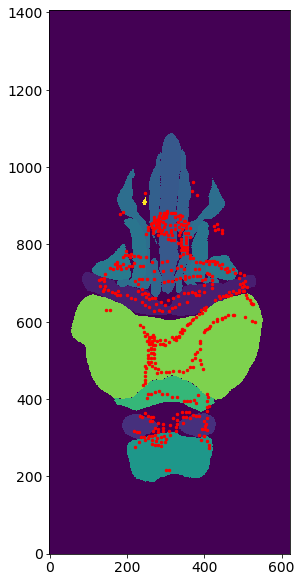

In [52]:
z_layer += 1
# z_layer = 50
ind_z_grid = np.where(grid_coordinates[:, 2] == z_layer)[0]

plot_baier = np.squeeze(baier_ref[:, :, z_layer])
plt.imshow(plot_baier.T, origin='lower')

plot_grid = grid_coordinates[ind_z_grid, :]
plt.scatter(plot_grid[:, 0], plot_grid[:, 1], s=6, color='red')
print(f'Layer = {z_layer}')

In [53]:
## Label neurons according to Baier atlas

grid_labels = np.zeros(grid_coordinates.shape[0])  # zero = not labelled
for n in range(grid_coordinates.shape[0]):
    if grid_coordinates[n, 2] < 138:  # some neurons exceed zbrain space limit, do not label (i.e. skip)
        # label by inserting grid coordinates in baier atlas to obtain unique label at that point
        grid_labels[n] = baier_ref[grid_coordinates[n, 0], grid_coordinates[n, 1], grid_coordinates[n, 2]]
        

In [54]:
## Determine whether left or right

right_bool = np.zeros(grid_coordinates.shape[0])
## check in fishualizer: x: L -> R
x_med = int(0.5 * baier_ref.shape[0])  # median
right_bool[grid_coordinates[:, 0] > x_med] = 1  # greater than median = RIGHT
# plt.plot(right_bool, grid_coordinates[:, 0], '.')
print(f'Fraction right {np.sum(right_bool) / len(right_bool)}')

Fraction right 0.5192872397223706


In [55]:
grid_rl_labels = 2 * grid_labels - 1 
grid_rl_labels[grid_rl_labels < 0] = 0
grid_rl_labels[grid_rl_labels != 0] += right_bool[grid_rl_labels != 0]
# plt.plot(grid_labels, grid_rl_labels, '.')
print('Percentage labelled', np.round(np.sum(grid_labels != 0) / len(grid_labels), 3))
np.unique(grid_rl_labels)  # labelled regions

Percentage labelled 0.843


array([ 0.,  5.,  6.,  9., 10., 16., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 34., 37., 38., 41., 42., 47., 48., 49.,
       50., 57., 58., 59., 60., 61., 62., 63., 64., 69., 70., 71., 72.])

In [56]:
## create file names for saving 

save_path_repo = '/home/thijs/repos/zf-rbm/baier_atlas_labels'
save_path_data = '/media/thijs/hooghoudt/Zebrafish_data/spontaneous_data_guillaume_T22/baier_labels'
file_name = f'/baier_region-labels__{data_set}__labelled-{datetime.date.today()}.npy'
print(file_name)

file_name_rl = f'/baier_rl-region-labels__{data_set}__labelled-{datetime.date.today()}.npy'
print(file_name_rl)

/baier_region-labels__20191126_Run02__labelled-2020-10-15.npy
/baier_rl-region-labels__20191126_Run02__labelled-2020-10-15.npy


In [57]:
## save

np.save(arr=grid_labels, file=save_path_repo + file_name)
np.save(arr=grid_rl_labels, file=save_path_repo + file_name_rl)

np.save(arr=grid_labels, file=save_path_data + file_name)
np.save(arr=grid_rl_labels, file=save_path_data + file_name_rl)